In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# feature extraction
from skimage.measure import regionprops, perimeter, find_contours, label
from skimage.morphology import convex_hull_image, skeletonize
from skimage.feature import graycomatrix, graycoprops, hog
from scipy.stats import skew, kurtosis
from numpy.fft import fft
from skimage import filters, feature, io, color
from skimage.filters import laplace, gaussian
from skimage.feature import hog
from scipy.ndimage import gaussian_laplace, gaussian_filter, sobel


In [ ]:
# mount drive
folder_path = # path to input data


binary_mask_dir = os.path.join(folder_path, "Dataset Binary/")
intensity_dir = os.path.join(folder_path, "Dataset Intensity 2/")

print(binary_mask_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Research/Uma_Research_Project/Spring 2025/PAPER: Advancing Dendritic Spine Morphometry Analysis: Clustering for Understanding Shape Distributions and Synaptic Plasticity/Dataset Binary/


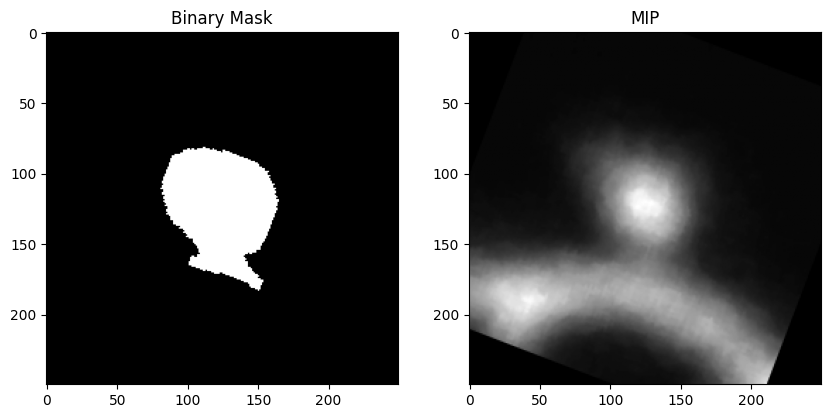

In [ ]:
# viewing example image
binary_masks = sorted([f for f in os.listdir(binary_mask_dir) if f.endswith('.png')])
intensity_images = sorted([f for f in os.listdir(intensity_dir) if f.endswith('.png')])

sample_mask_path = os.path.join(binary_mask_dir, binary_masks[0])
sample_intensity_path = os.path.join(intensity_dir, intensity_images[0])

binary_mask = io.imread(sample_mask_path, as_gray=True)
intensity_image = io.imread(sample_intensity_path, as_gray=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(binary_mask, cmap='gray')
ax[0].set_title('Binary Mask')
ax[1].imshow(intensity_image, cmap='gray')
ax[1].set_title('MIP')

plt.show()

In [ ]:
# feature computation
results = []

for n in range(1, 457):
    binary_path = os.path.join(binary_mask_dir, f"{n}.png")
    intensity_path = os.path.join(intensity_dir, f"{n}.png")

    # load images
    binary_mask = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
    intensity_img = cv2.imread(intensity_path, cv2.IMREAD_GRAYSCALE)

    if binary_mask is None or intensity_img is None:
        print(f"Skipping {n}.png, file not found")
        continue

    # threshold and normalize binary mask
    _, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    binary_mask = binary_mask // 255

    # set background in MIP to 0
    masked_intensity = intensity_img * binary_mask
    props = regionprops(binary_mask)[0]

    # perimeter
    perim = perimeter(binary_mask)

    # convex Hull Ratio
    convex_hull = convex_hull_image(binary_mask)
    convex_hull_area = np.sum(convex_hull)
    convex_hull_ratio = props.area / convex_hull_area if convex_hull_area != 0 else 0

    # circularity
    circularity = (4 * np.pi * props.area) / (perim ** 2) if perim != 0 else 0

    # curvature (contours)
    contours = find_contours(binary_mask, level=0.5)
    if len(contours) > 0:
        contour = contours[0]
        dx = np.gradient(contour[:, 1])
        dy = np.gradient(contour[:, 0])
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)
        curvature = np.abs(ddx * dy - dx * ddy) / (dx ** 2 + dy ** 2) ** 1.5
        mean_curvature = np.mean(curvature)
    else:
        mean_curvature = 0

    # solidity
    solidity = props.area / convex_hull_area if convex_hull_area != 0 else 0

    # eccentricity
    eccentricity = props.eccentricity

    # intensity Features
    intensity_values = masked_intensity[masked_intensity > 0].flatten()
    mean_intensity = np.mean(intensity_values)
    std_intensity = np.std(intensity_values)
    skewness = skew(intensity_values)
    kurt = kurtosis(intensity_values)

    # GLCM Features
    glcm = graycomatrix(intensity_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # fourier Descriptors
    fourier_descriptor = fft(contour[:, 0] + 1j * contour[:, 1]) if len(contours) > 0 else [0]
    fourier_magnitude = np.abs(fourier_descriptor)
    fourier_mean = np.mean(fourier_magnitude)
    fourier_std = np.std(fourier_magnitude)

    # fractal Dimension
    fractal_dimension = np.log(perim) / np.log(props.area) if props.area != 0 else 0

    # HOG Features
    hog_features = hog(binary_mask, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)

    results.append({
        "Spine Label": n,
        "Convex Hull Ratio": convex_hull_ratio,
        "Circularity": circularity,
        "Curvature": mean_curvature,
        "Solidity": solidity,
        "Eccentricity": eccentricity,
        "Mean_Intensity": mean_intensity,
        "Std_Intensity": std_intensity,
        "Skewness": skewness,
        "Kurtosis": kurt,
        "GLCM_Contrast": contrast,
        "GLCM_Homogeneity": homogeneity,
        "GLCM_Correlation": correlation,
        "Fourier_Mean": fourier_mean,
        "Fourier_Std": fourier_std,
        "Fractal_Dimension": fractal_dimension,
        "HOG_Mean": hog_mean,
        "HOG_Std": hog_std
    })

df = pd.DataFrame(results)
df.to_csv("dendritic_spine_morphology_full.csv", index=False)
print("Complete")
